In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy

import numpy as np
import torch
import tqdm

import matplotlib.pyplot as plt 

# from ray import tune

import stable_baselines3
from stable_baselines3.common import vec_env, monitor


import autonomous_optimizer
import benchmark

First, open up a terminal window and run
```bash
$ tensorboard --logdir tb_logs
```

Then open up the tensorboard interface, usually at [http://localhost:6006](http://localhost:6006)



## Convex Quadratics

First, we will examine performance on convex quadratic objective functions. We generate 90 convex quadratics in two dimensions with eigenvalues uniformly distributed between 1 and 30 as the train set.

In [3]:
quadratic_dataset = [benchmark.convex_quadratic() for _ in range(90)]

/home/raul/FGV/5 periodo/ML/final_trabalho/Learning-to-Optimize-main/benchmark.py:50: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  return 0.5 * x.T @ A @ x + b.T @ x


Now we define the RL environment and our model.

In [6]:
quadratic_env = vec_env.DummyVecEnv([
    lambda: monitor.Monitor(
        autonomous_optimizer.Environment(quadratic_dataset, num_steps=40, history_len=25)
    )
]*32)

quadratic_policy = stable_baselines3.PPO('MlpPolicy', quadratic_env, n_steps=2, verbose=0,
                                         tensorboard_log='tb_logs/quadratic')

[autoreload of stable_baselines3.common.vec_env.base_vec_env failed: Traceback (most recent call last):
  File "/home/raul/FGV/5 periodo/ML/final_trabalho/Learning-to-Optimize-main/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/raul/FGV/5 periodo/ML/final_trabalho/Learning-to-Optimize-main/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/raul/FGV/5 periodo/ML/final_trabalho/Learning-to-Optimize-main/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/raul/FGV/5 periodo/ML/final_trabalho/Learning-to-Optimize-main/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/raul/FGV/5 periodo/ML/final_trabalho/Learning-to-Optimize-ma

Train the algorithm on 20 passes over the dataset

In [7]:
quadratic_policy.learn(total_timesteps=20 * quadratic_env.envs[0].num_steps * len(quadratic_dataset))

We will be comparing the RL optimizer to several common convex optimization algorithms. We use Bayesian optimization to find good hyperparameters for this class of problems. And to make this a fair comparison, we will also run 20 passes over all problems in the dataset, just like the RL algorithm gets.

In [8]:
quadratic_tune = {
    "sgd": {"hyperparams": {"lr": 5e-2}},
    "momentum": {"hyperparams": {"lr": 1e-2, "momentum": 0.7}},
    "adam": {"hyperparams": {"lr": 1e-1}},
    "lbfgs": {"hyperparams": {"lr": 1, "max_iter": 1}}
}

Now, let's compare their behavior on an example problem.

In [9]:
problem = benchmark.convex_quadratic()

model0 = problem["model0"]
obj_function = problem["obj_function"]
optimal_x = problem["optimal_x"]
optimal_value = problem["optimal_val"]
A = problem["A"]
b = problem["b"]
    
print(f'Objective function minimum: {optimal_value}')

Objective function minimum: -0.06616313010454178


Run algos with our tuned hyperparams

In [10]:
iterations = 40

results = benchmark.run_all_optimizers(problem, iterations, quadratic_tune, quadratic_policy)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

SGD best loss: -0.06616313755512238
Momentum best loss: -0.06616290658712387
Adam best loss: -0.06296753883361816
LBFGS best loss: -0.06616313010454178
Autonomous Optimizer best loss: -0.06190304458141327


Distance from optimal vs iteration

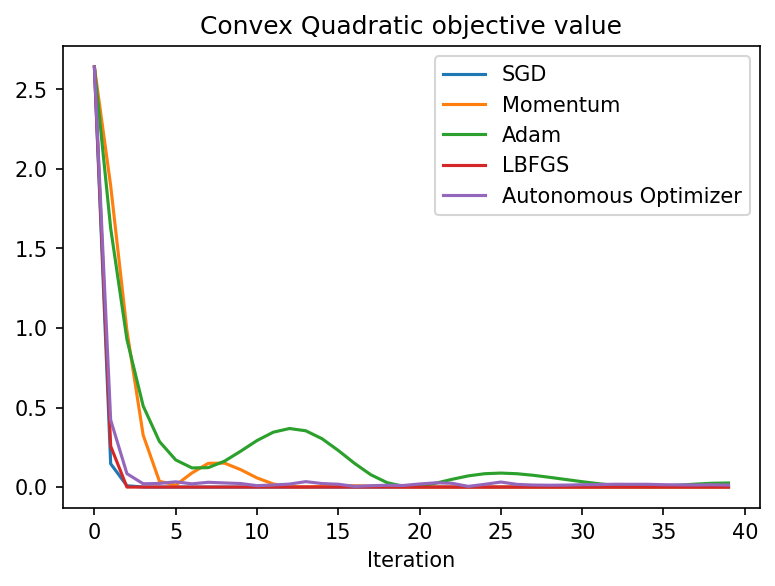

In [11]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('Convex Quadratic objective value')
plt.plot(sgd_vals - optimal_value, label='SGD')
plt.plot(momentum_vals - optimal_value, label='Momentum')
plt.plot(adam_vals - optimal_value, label='Adam')
plt.plot(lbfgs_vals - optimal_value, label='LBFGS')
plt.plot(ao_vals - optimal_value, label='Autonomous Optimizer')

plt.xlabel('Iteration')
plt.legend()
plt.show()

Plotting trajectories on a 2-D slice of the parameter space

In [ ]:
# codigo antigo, nao funciona
def get_weights(model):
    return model.x[0].item(), model.x[1].item()

def set_weights(model, w1, w2):
    model.x[0] = w1
    model.x[1] = w2

benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)

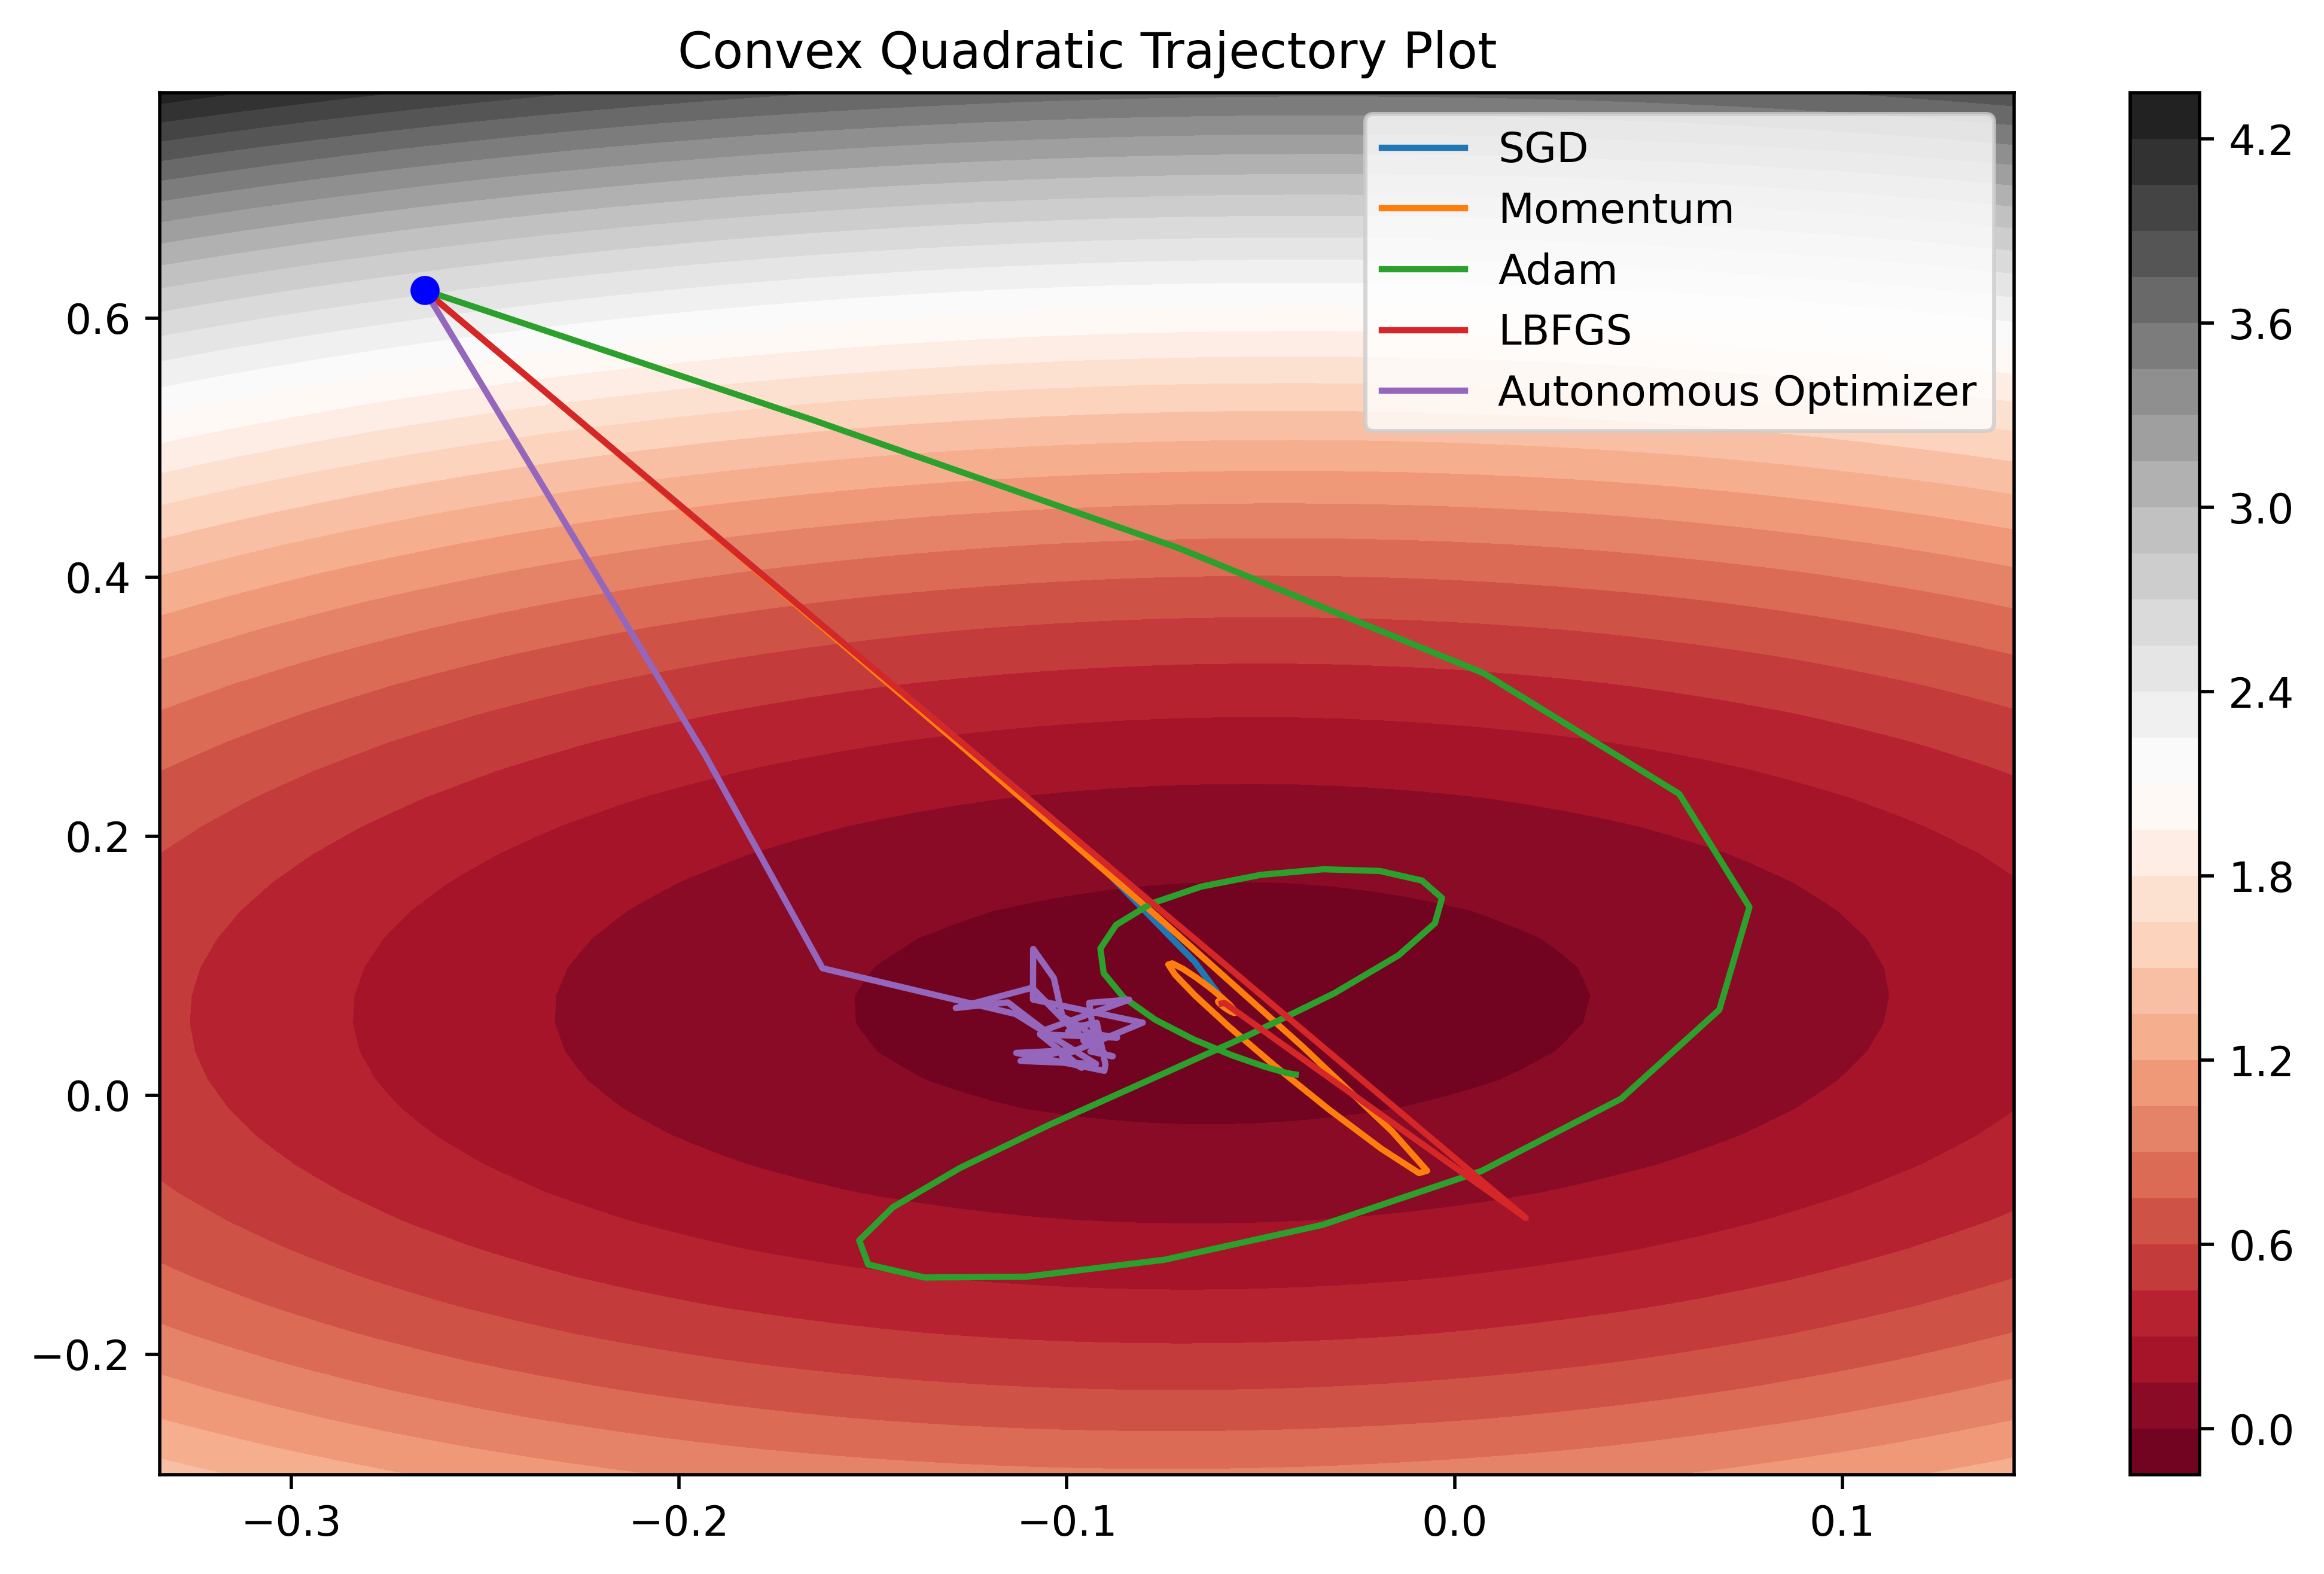

In [16]:
def get_weights(model):
    return model.x.detach().numpy()[0], model.x.detach().numpy()[1]

def set_weights(model, w1, w2):
    model.x = torch.nn.Parameter(torch.tensor([w1, w2], dtype=torch.float32), requires_grad=True)


benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)

## Logistic Regression

In [25]:
lr_dataset = [benchmark.logistic_regression() for _ in range(90)]

In [26]:
lr_env = vec_env.DummyVecEnv([
    lambda: monitor.Monitor(
        autonomous_optimizer.Environment(lr_dataset, num_steps=40, history_len=25)
    )
]*32)

lr_policy = stable_baselines3.PPO('MlpPolicy', lr_env, n_steps=1, verbose=0,
                                  tensorboard_log='tb_logs/lr')

/home/raul/FGV/5 periodo/ML/final_trabalho/Learning-to-Optimize-main/venv/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:131: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 32`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 32
We recommend using a `batch_size` that is a multiple of `n_steps * n_envs`.
Info: (n_steps=1 and n_envs=32)
  # Sanity check, otherwise it will lead to noisy gradient and NaN


In [27]:
lr_policy.learn(total_timesteps=20 * lr_env.envs[0].num_steps * len(lr_dataset))

In [28]:
lr_tune = {
    "sgd": {"hyperparams": {"lr": 1e-1}},
    "momentum": {"hyperparams": {"lr": 5e-1, "momentum": 0.85}},
    "adam": {"hyperparams": {"lr": 5e-1}},
    "lbfgs": {"hyperparams": {"lr": 1, "max_iter": 1}}
}

In [29]:
problem = benchmark.logistic_regression()

model0 = problem["model0"]
obj_function = problem["obj_function"]
x, y = problem["data"]

In [30]:
iterations = 40

results = benchmark.run_all_optimizers(problem, iterations, lr_tune, lr_policy)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

sgd_accuracy = np.array([benchmark.accuracy(model, x, y) for model in sgd_traj])
momentum_accuracy = np.array([benchmark.accuracy(model, x, y) for model in momentum_traj])
adam_accuracy = np.array([benchmark.accuracy(model, x, y) for model in adam_traj])
lbfgs_accuracy = np.array([benchmark.accuracy(model, x, y) for model in lbfgs_traj])
ao_accuracy = np.array([benchmark.accuracy(model, x, y) for model in ao_traj])

print(f'\nSGD best accuracy: {sgd_accuracy.max()}')
print(f'Momentum best accuracy: {momentum_accuracy.max()}')
print(f'Adam best accuracy: {adam_accuracy.max()}')
print(f'LBFGS best accuracy: {lbfgs_accuracy.max()}')
print(f'Autonomous optimizer best accuracy: {ao_accuracy.max()}')

SGD best loss: 0.3944271206855774
Momentum best loss: 0.31978553533554077
Adam best loss: 0.31948021054267883
LBFGS best loss: 0.3193846046924591
Autonomous Optimizer best loss: 0.3312409818172455

SGD best accuracy: 0.8700000047683716
Momentum best accuracy: 0.8799999952316284
Adam best accuracy: 0.8700000047683716
LBFGS best accuracy: 0.8700000047683716
Autonomous optimizer best accuracy: 0.8600000143051147


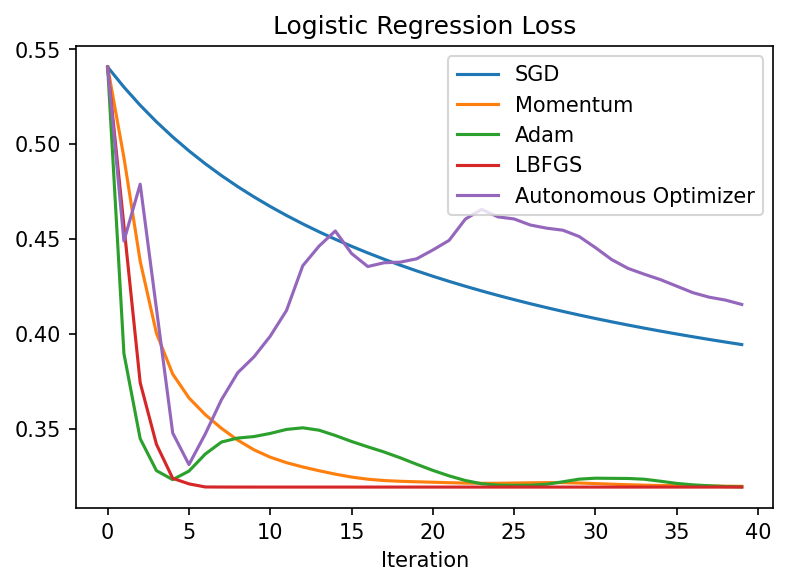

In [31]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('Logistic Regression Loss')
plt.plot(sgd_vals, label='SGD')
plt.plot(momentum_vals, label='Momentum')
plt.plot(adam_vals, label='Adam')
plt.plot(lbfgs_vals, label='LBFGS')
plt.plot(ao_vals, label='Autonomous Optimizer')

plt.xlabel('Iteration')
plt.legend()
plt.show()

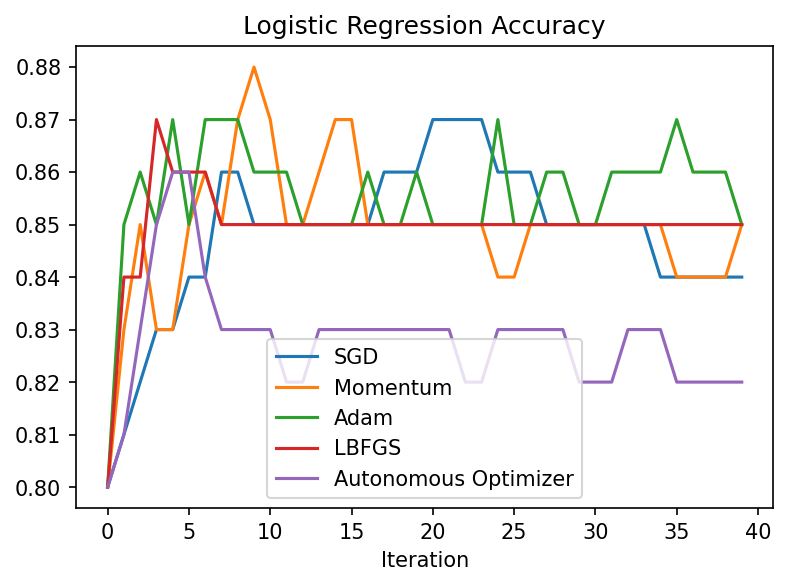

In [32]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('Logistic Regression Accuracy')
plt.plot(sgd_accuracy, label='SGD')
plt.plot(momentum_accuracy, label='Momentum')
plt.plot(adam_accuracy, label='Adam')
plt.plot(lbfgs_accuracy, label='LBFGS')
plt.plot(ao_accuracy, label='Autonomous Optimizer')

plt.xlabel('Iteration')
plt.legend()
plt.show()

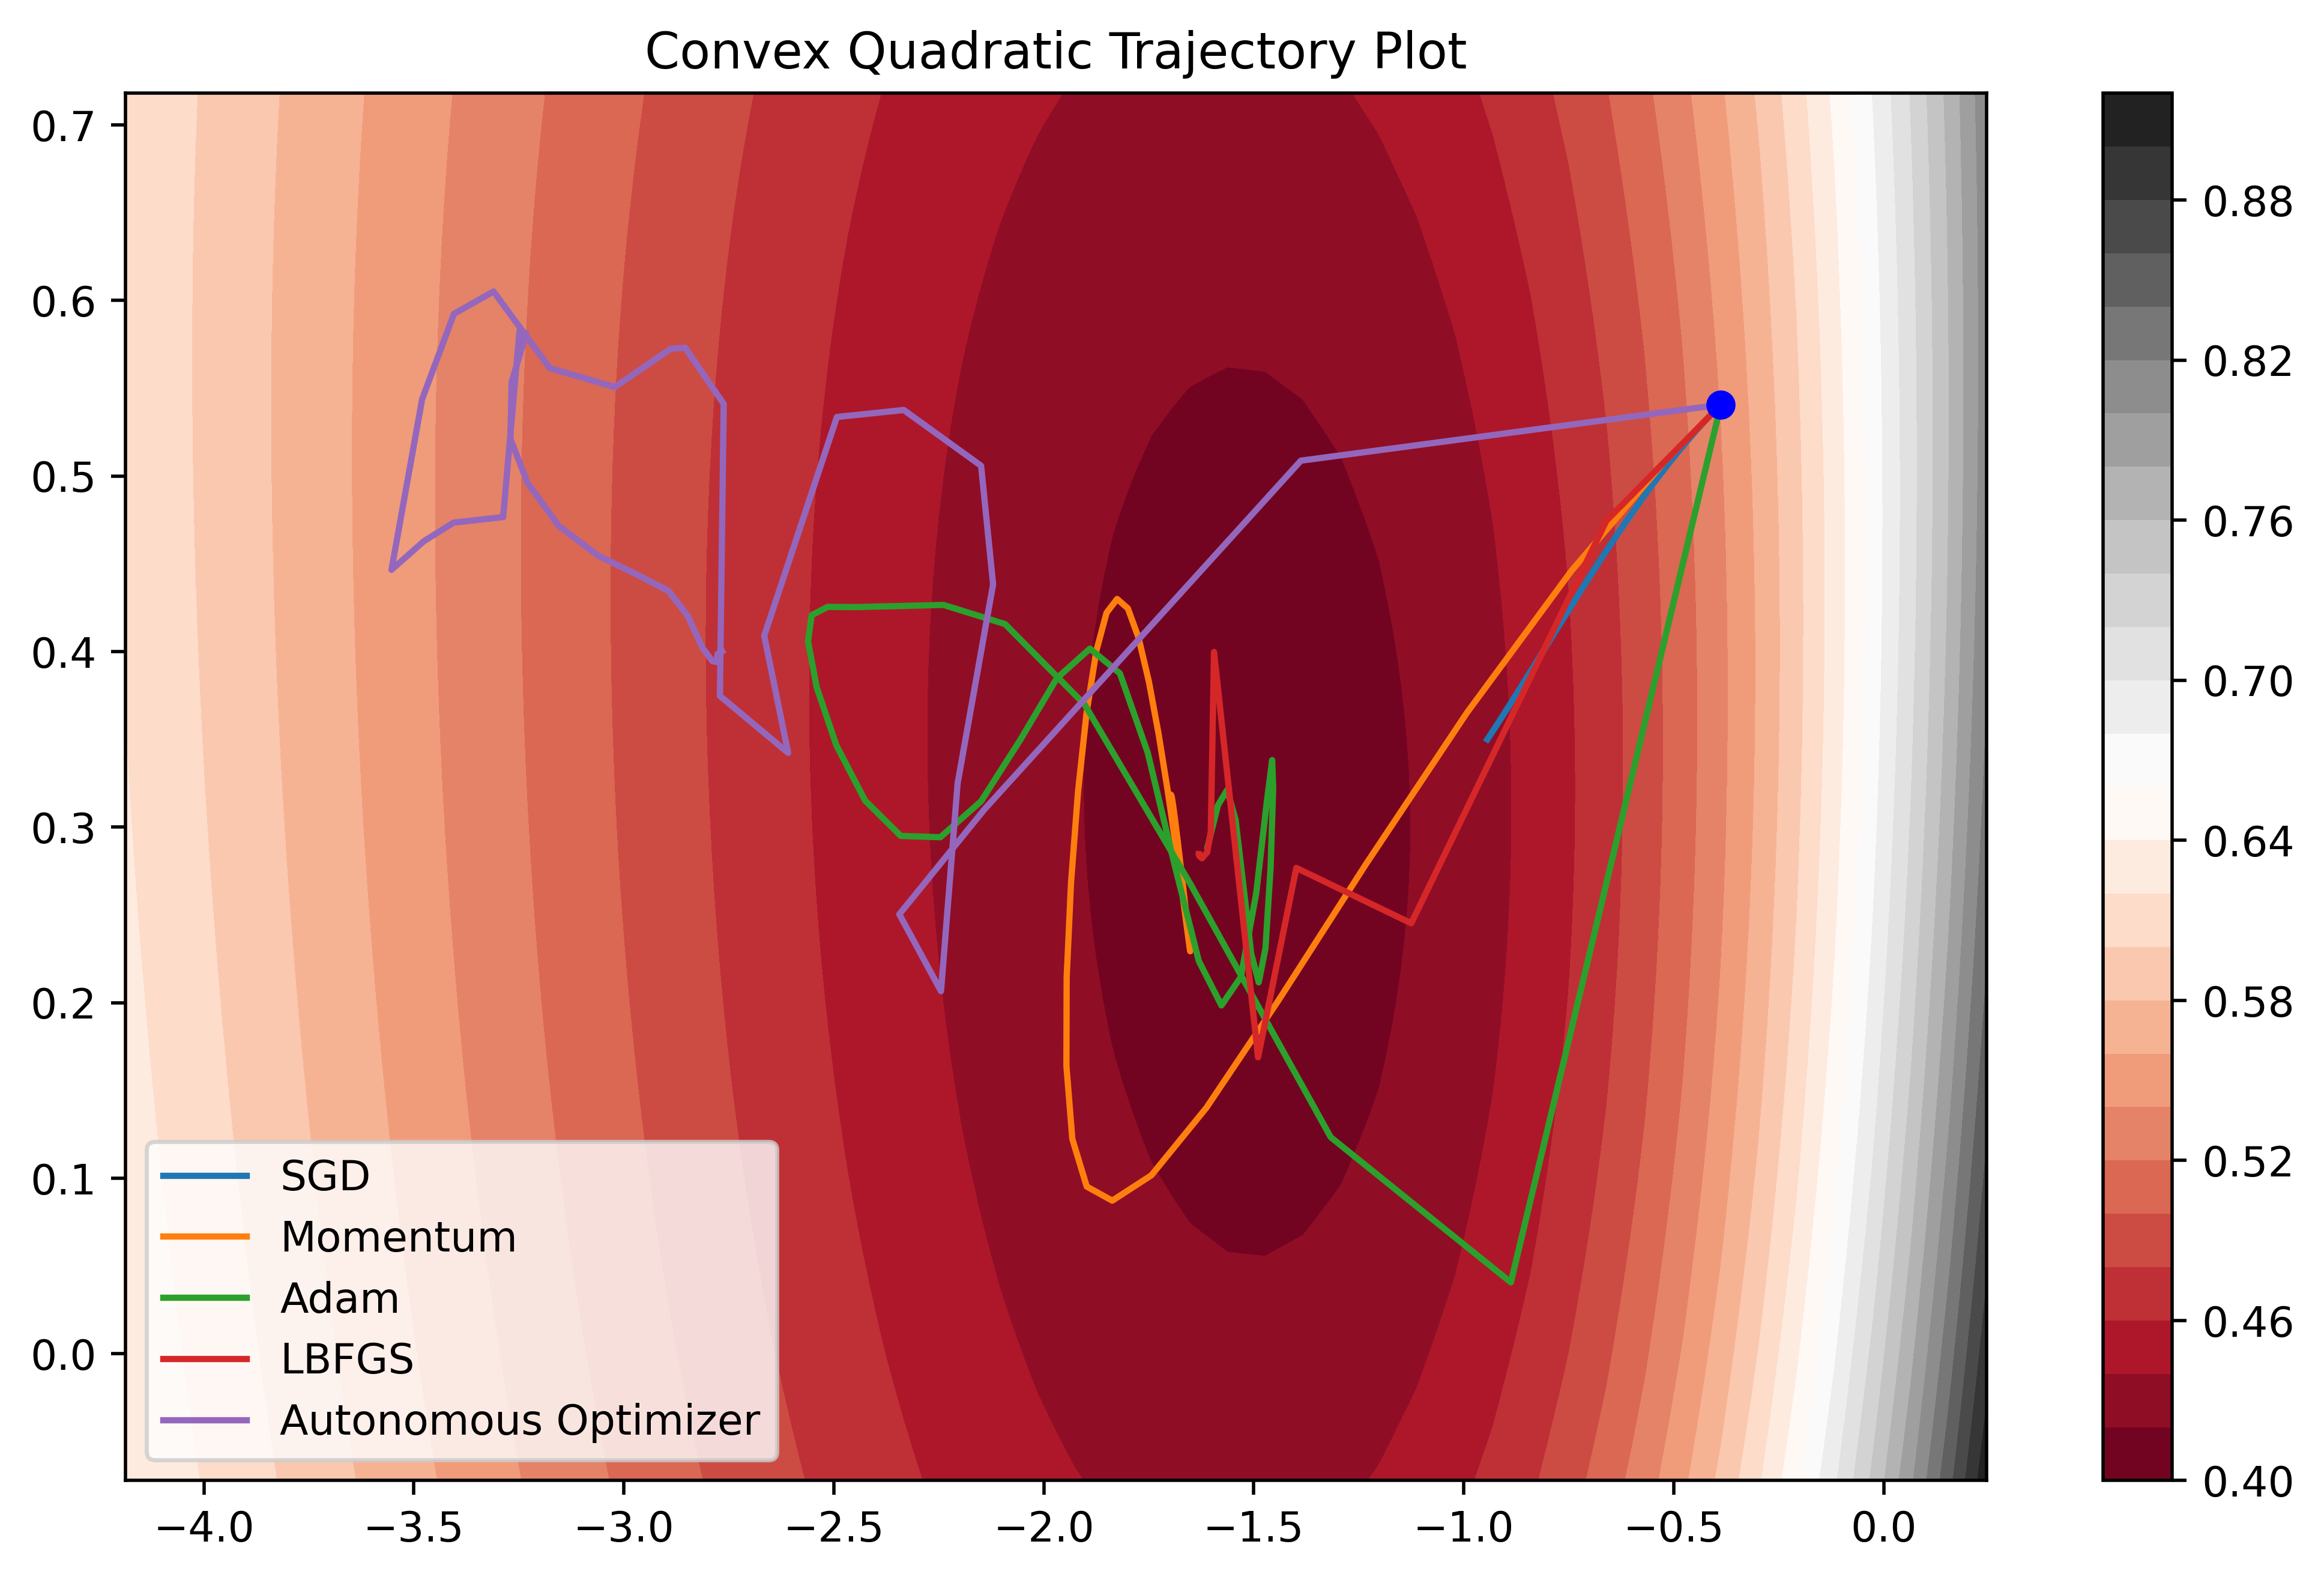

In [35]:
def get_weights(model):
    return model[0].weight[0, 0].item(), model[0].weight[0, 1].item()

def set_weights(model, w1, w2):
    # alterei isso, mas nem faz mt sentido, mas roda
    with torch.no_grad():
        model[0].weight.data[0, 0] = w1
        model[0].weight.data[0, 1] = w2



benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)

## Robust Linear Regression

In [37]:
rlr_dataset = [benchmark.robust_linear_regression() for _ in range(120)]

In [38]:
rlr_env = vec_env.DummyVecEnv([
    lambda: monitor.Monitor(
        autonomous_optimizer.Environment(rlr_dataset, num_steps=40, history_len=25)
    )
]*32)

rlr_policy = stable_baselines3.PPO('MlpPolicy', rlr_env, n_steps=1, verbose=0,
                                   tensorboard_log='tb_logs/rlr')

In [39]:
rlr_policy.learn(total_timesteps=125 * rlr_env.envs[0].num_steps * len(rlr_dataset))

In [44]:
rlr_tune = {
    "sgd": {"hyperparams": {"lr": 5e-1}},
    "momentum": {"hyperparams": {"lr": 5e-1, "momentum": 0.9}},
    "adam": {"hyperparams": {"lr": 5e-1}},
    "lbfgs": {"hyperparams": {"lr": 0.1, "max_iter": 1}}
}

In [45]:
problem = benchmark.robust_linear_regression()

model0 = problem["model0"]
obj_function = problem["obj_function"]

In [46]:
iterations = 40

results = benchmark.run_all_optimizers(problem, iterations, rlr_tune, rlr_policy)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

SGD best loss: 0.4125100076198578
Momentum best loss: 0.41064947843551636
Adam best loss: 0.4102645814418793
LBFGS best loss: 0.5312219858169556
Autonomous Optimizer best loss: 0.45559147000312805


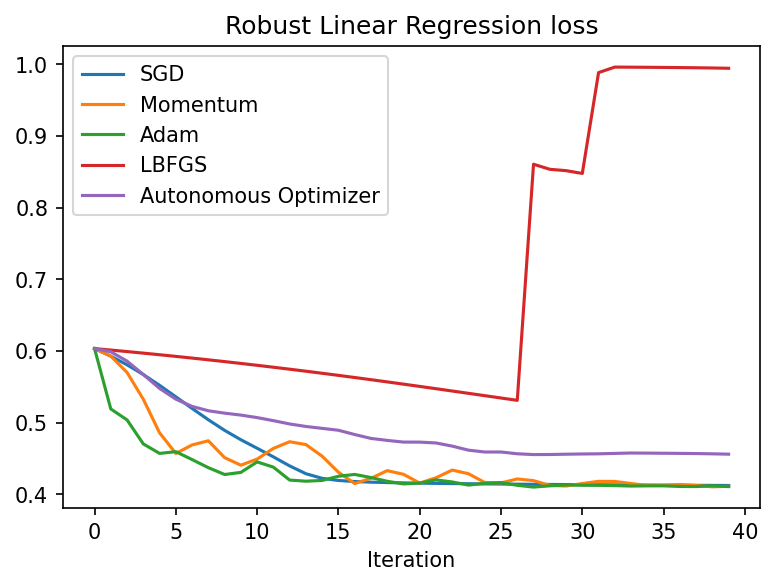

In [47]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('Robust Linear Regression loss')
plt.plot(sgd_vals, label='SGD')
plt.plot(momentum_vals, label='Momentum')
plt.plot(adam_vals, label='Adam')
plt.plot(lbfgs_vals, label='LBFGS')
plt.plot(ao_vals, label='Autonomous Optimizer')

plt.xlabel('Iteration')
plt.legend()
plt.show()

In [48]:
def get_weights(model):
    return model.weight[0, 0].item(), model.weight[0, 1].item()

def set_weights(model, w1, w2):
    model.weight[0, 0] = w1
    model.weight[0, 1] = w2

benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)

RuntimeError: a view of a leaf Variable that requires grad is being used in an in-place operation.

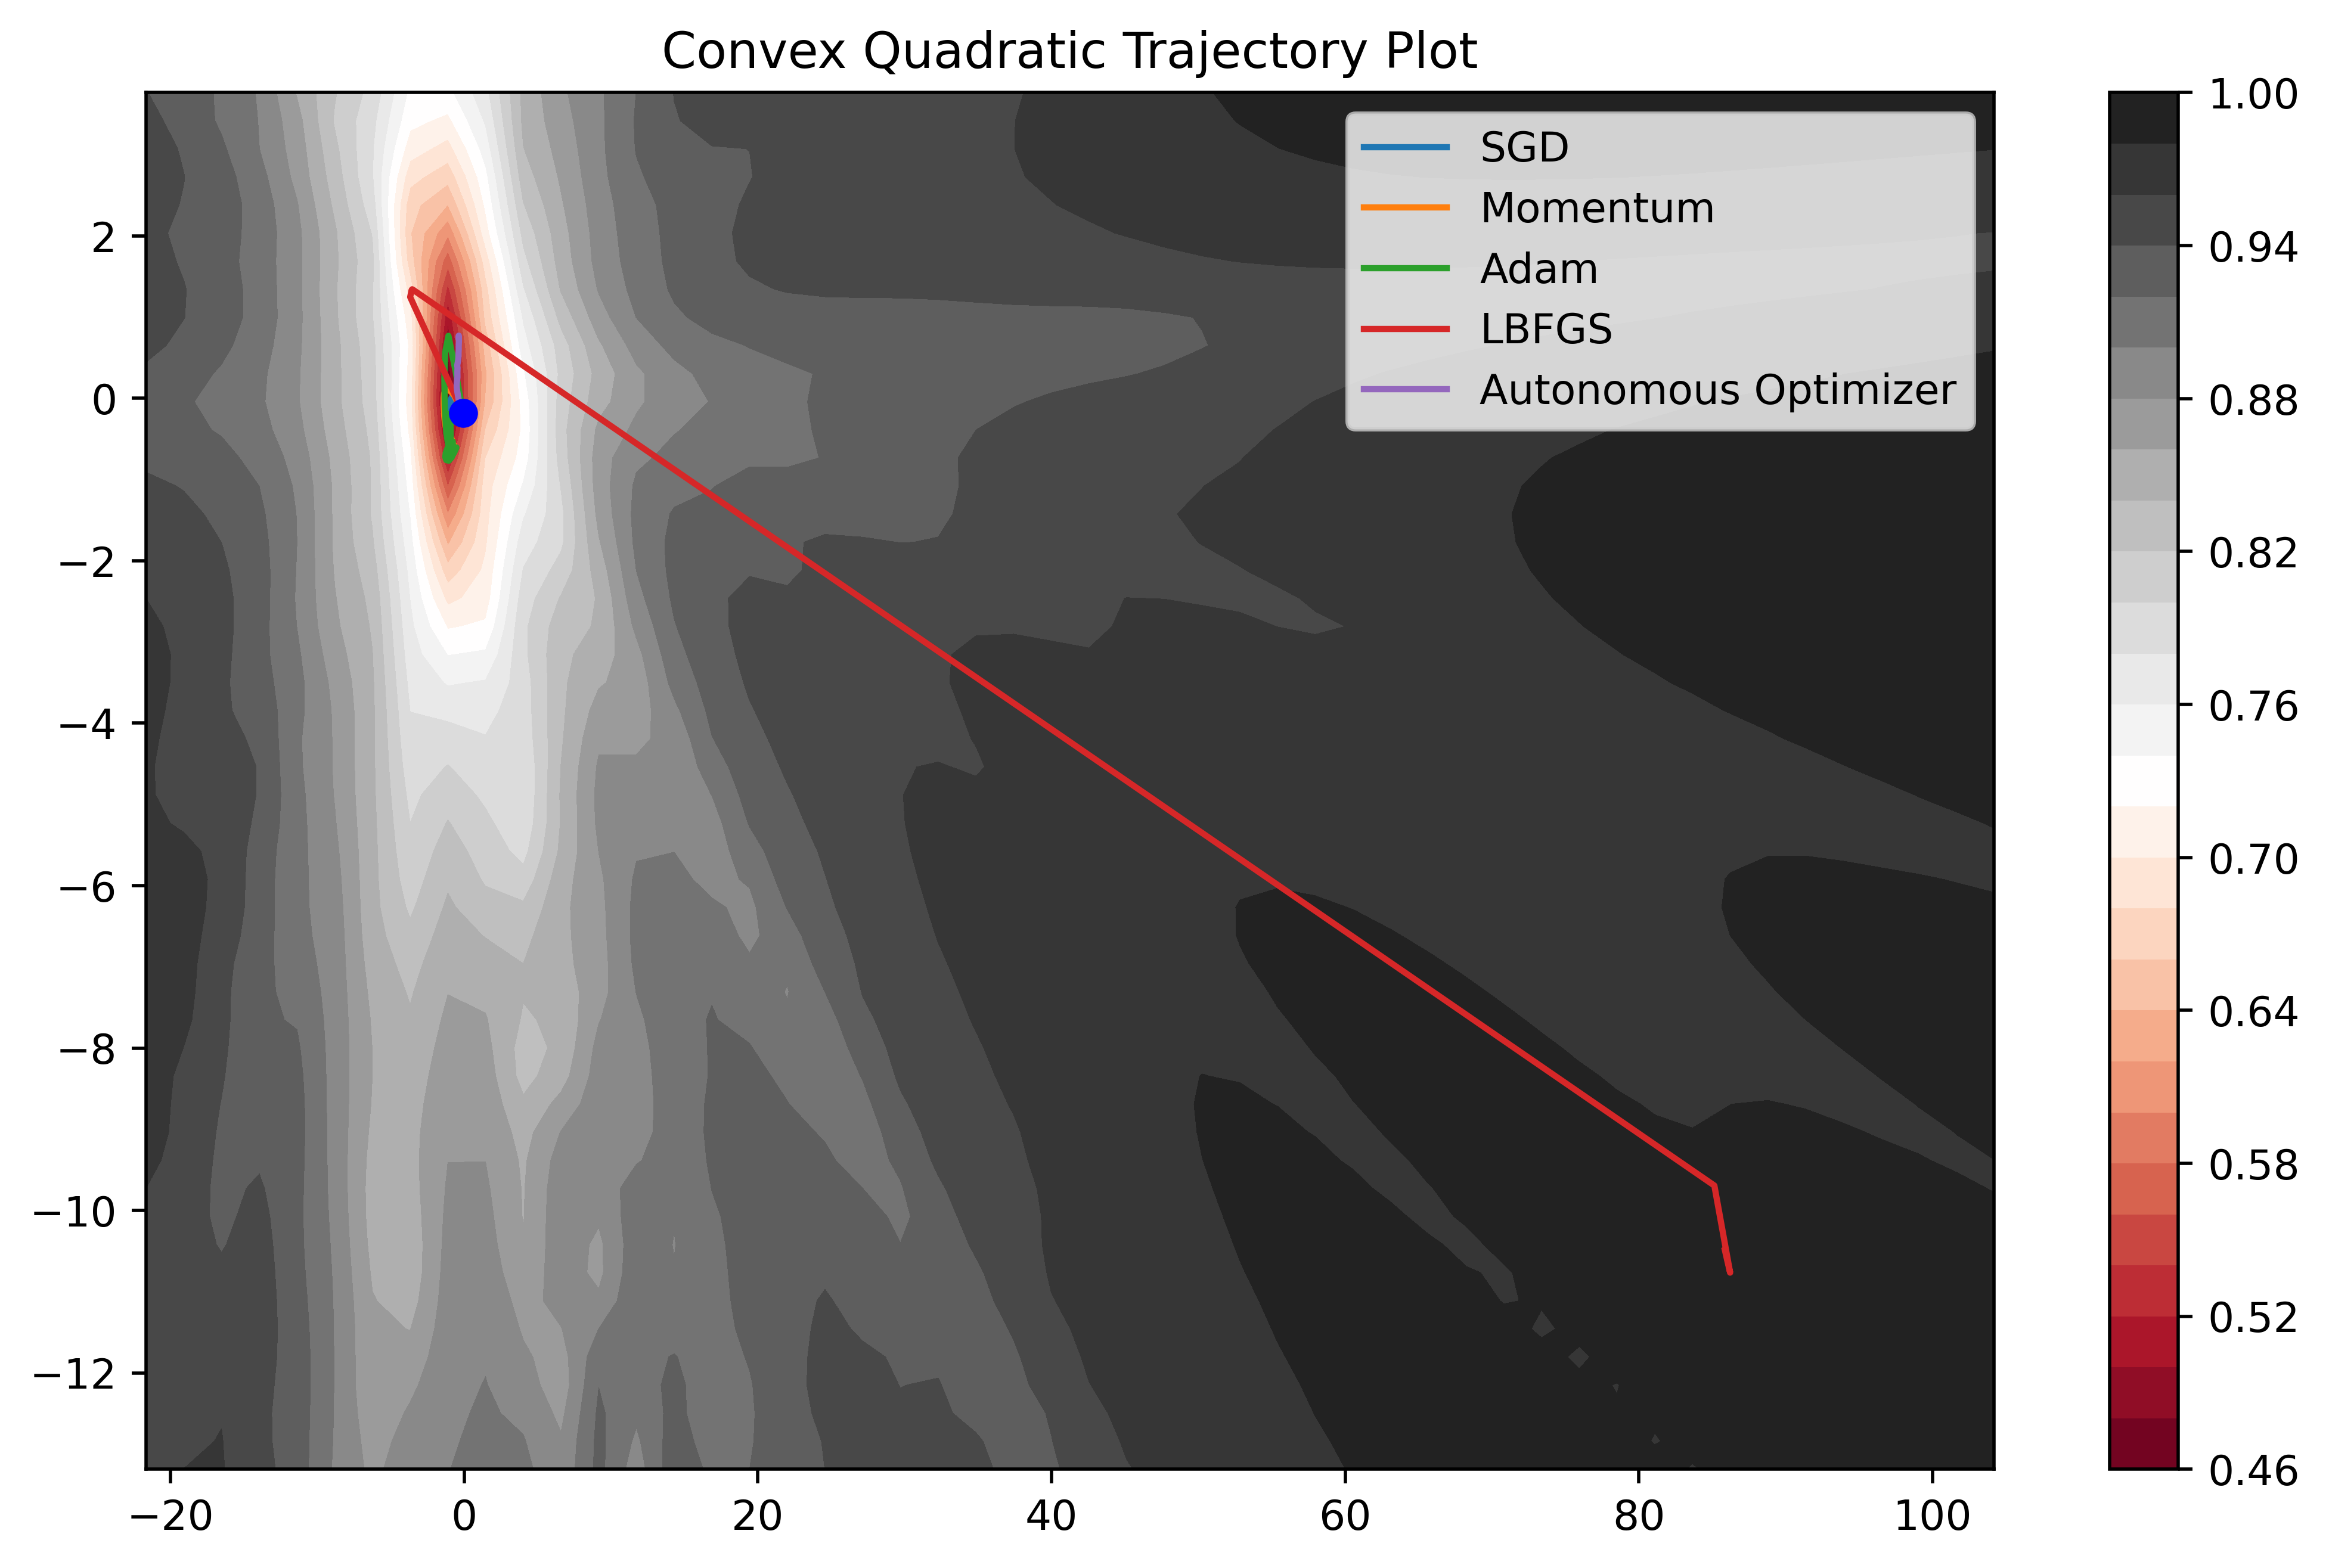

In [52]:
def get_weights(model):
    return model.weight[0, 0].item(), model.weight[0, 1].item()

def set_weights(model, w1, w2):
    with torch.no_grad():
        model.weight.data[0, 0] = w1
        model.weight.data[0, 1] = w2


benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)

## Optimizing a 2-layer neural net

In [53]:
mlp_dataset = [benchmark.mlp() for _ in range(80)]

In [54]:
mlp_env = vec_env.DummyVecEnv([
    lambda: monitor.Monitor(
        autonomous_optimizer.Environment(mlp_dataset, num_steps=40, history_len=25)
    )
]*64)

mlp_policy = stable_baselines3.PPO('MlpPolicy', mlp_env, n_steps=1, verbose=0,
                                   tensorboard_log='tb_logs/mlp')

In [55]:
mlp_policy.learn(total_timesteps=20 * mlp_env.envs[0].num_steps * len(mlp_dataset))

In [56]:
mlp_tune = {
    "sgd": {"hyperparams": {"lr": 3e-1}},
    "momentum": {"hyperparams": {"lr": 3e-1, "momentum": 0.9}},
    "adam": {"hyperparams": {"lr": 5e-1}},
    "lbfgs": {"hyperparams": {"lr": 0.1, "max_iter": 1}}
}

In [57]:
problem = benchmark.mlp()

model0 = problem["model0"]
obj_function = problem["obj_function"]
x, y = problem["dataset"]

In [59]:
iterations = 40

results = benchmark.run_all_optimizers(problem, iterations, mlp_tune, mlp_policy)
sgd_vals, sgd_traj = results["sgd"]
momentum_vals, momentum_traj = results["momentum"]
adam_vals, adam_traj = results["adam"]
lbfgs_vals, lbfgs_traj = results["lbfgs"]
ao_vals, ao_traj = results["ao"]

sgd_accuracy = np.array([benchmark.accuracy(model, x, y) for model in sgd_traj])
momentum_accuracy = np.array([benchmark.accuracy(model, x, y) for model in momentum_traj])
adam_accuracy = np.array([benchmark.accuracy(model, x, y) for model in adam_traj])
lbfgs_accuracy = np.array([benchmark.accuracy(model, x, y) for model in lbfgs_traj])
ao_accuracy = np.array([benchmark.accuracy(model, x, y) for model in ao_traj])

print(f'\nSGD best accuracy: {sgd_accuracy.max()}')
print(f'Momentum best accuracy: {momentum_accuracy.max()}')
print(f'Adam best accuracy: {adam_accuracy.max()}')
print(f'LBFGS best accuracy: {lbfgs_accuracy.max()}')
print(f'Autonomous optimizer best accuracy: {ao_accuracy.max()}')

SGD best loss: 0.48668912053108215
Momentum best loss: 0.4863491654396057
Adam best loss: 0.45664599537849426
LBFGS best loss: 0.45329341292381287
Autonomous Optimizer best loss: 0.6932927966117859

SGD best accuracy: 0.75
Momentum best accuracy: 0.75
Adam best accuracy: 0.800000011920929
LBFGS best accuracy: 0.8500000238418579
Autonomous optimizer best accuracy: 0.75


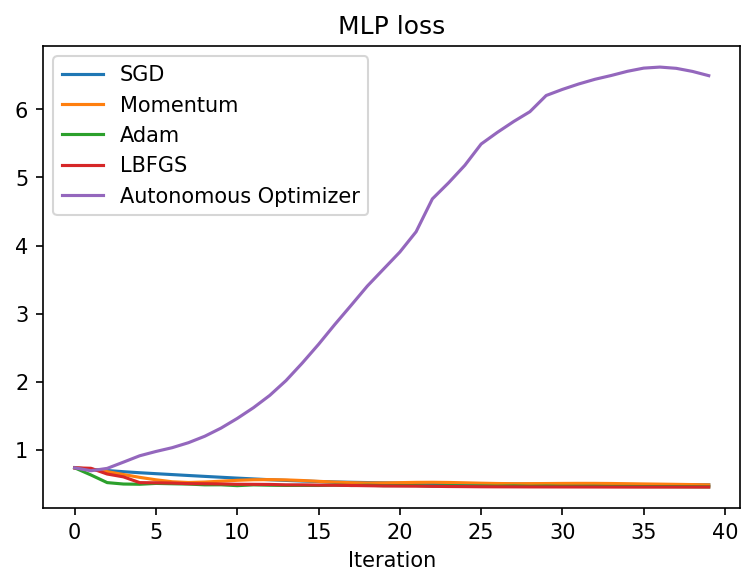

In [60]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('MLP loss')
plt.plot(sgd_vals, label='SGD')
plt.plot(momentum_vals, label='Momentum')
plt.plot(adam_vals, label='Adam')
plt.plot(lbfgs_vals, label='LBFGS')
plt.plot(ao_vals, label='Autonomous Optimizer')

if lbfgs_vals.max() > 1.5:
    plt.ylim(top=1.1)

plt.xlabel('Iteration')
plt.legend()
plt.show()

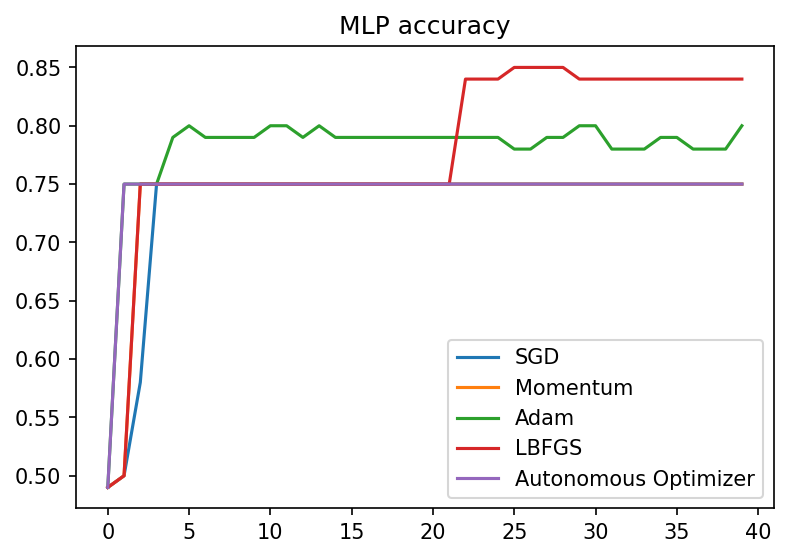

In [61]:
plt.figure(figsize=(6, 4), dpi=150)

plt.title('MLP accuracy')
plt.plot(sgd_accuracy, label='SGD')
plt.plot(momentum_accuracy, label='Momentum')
plt.plot(adam_accuracy, label='Adam')
plt.plot(lbfgs_accuracy, label='LBFGS')
plt.plot(ao_accuracy, label='Autonomous Optimizer')

plt.legend()
plt.show()

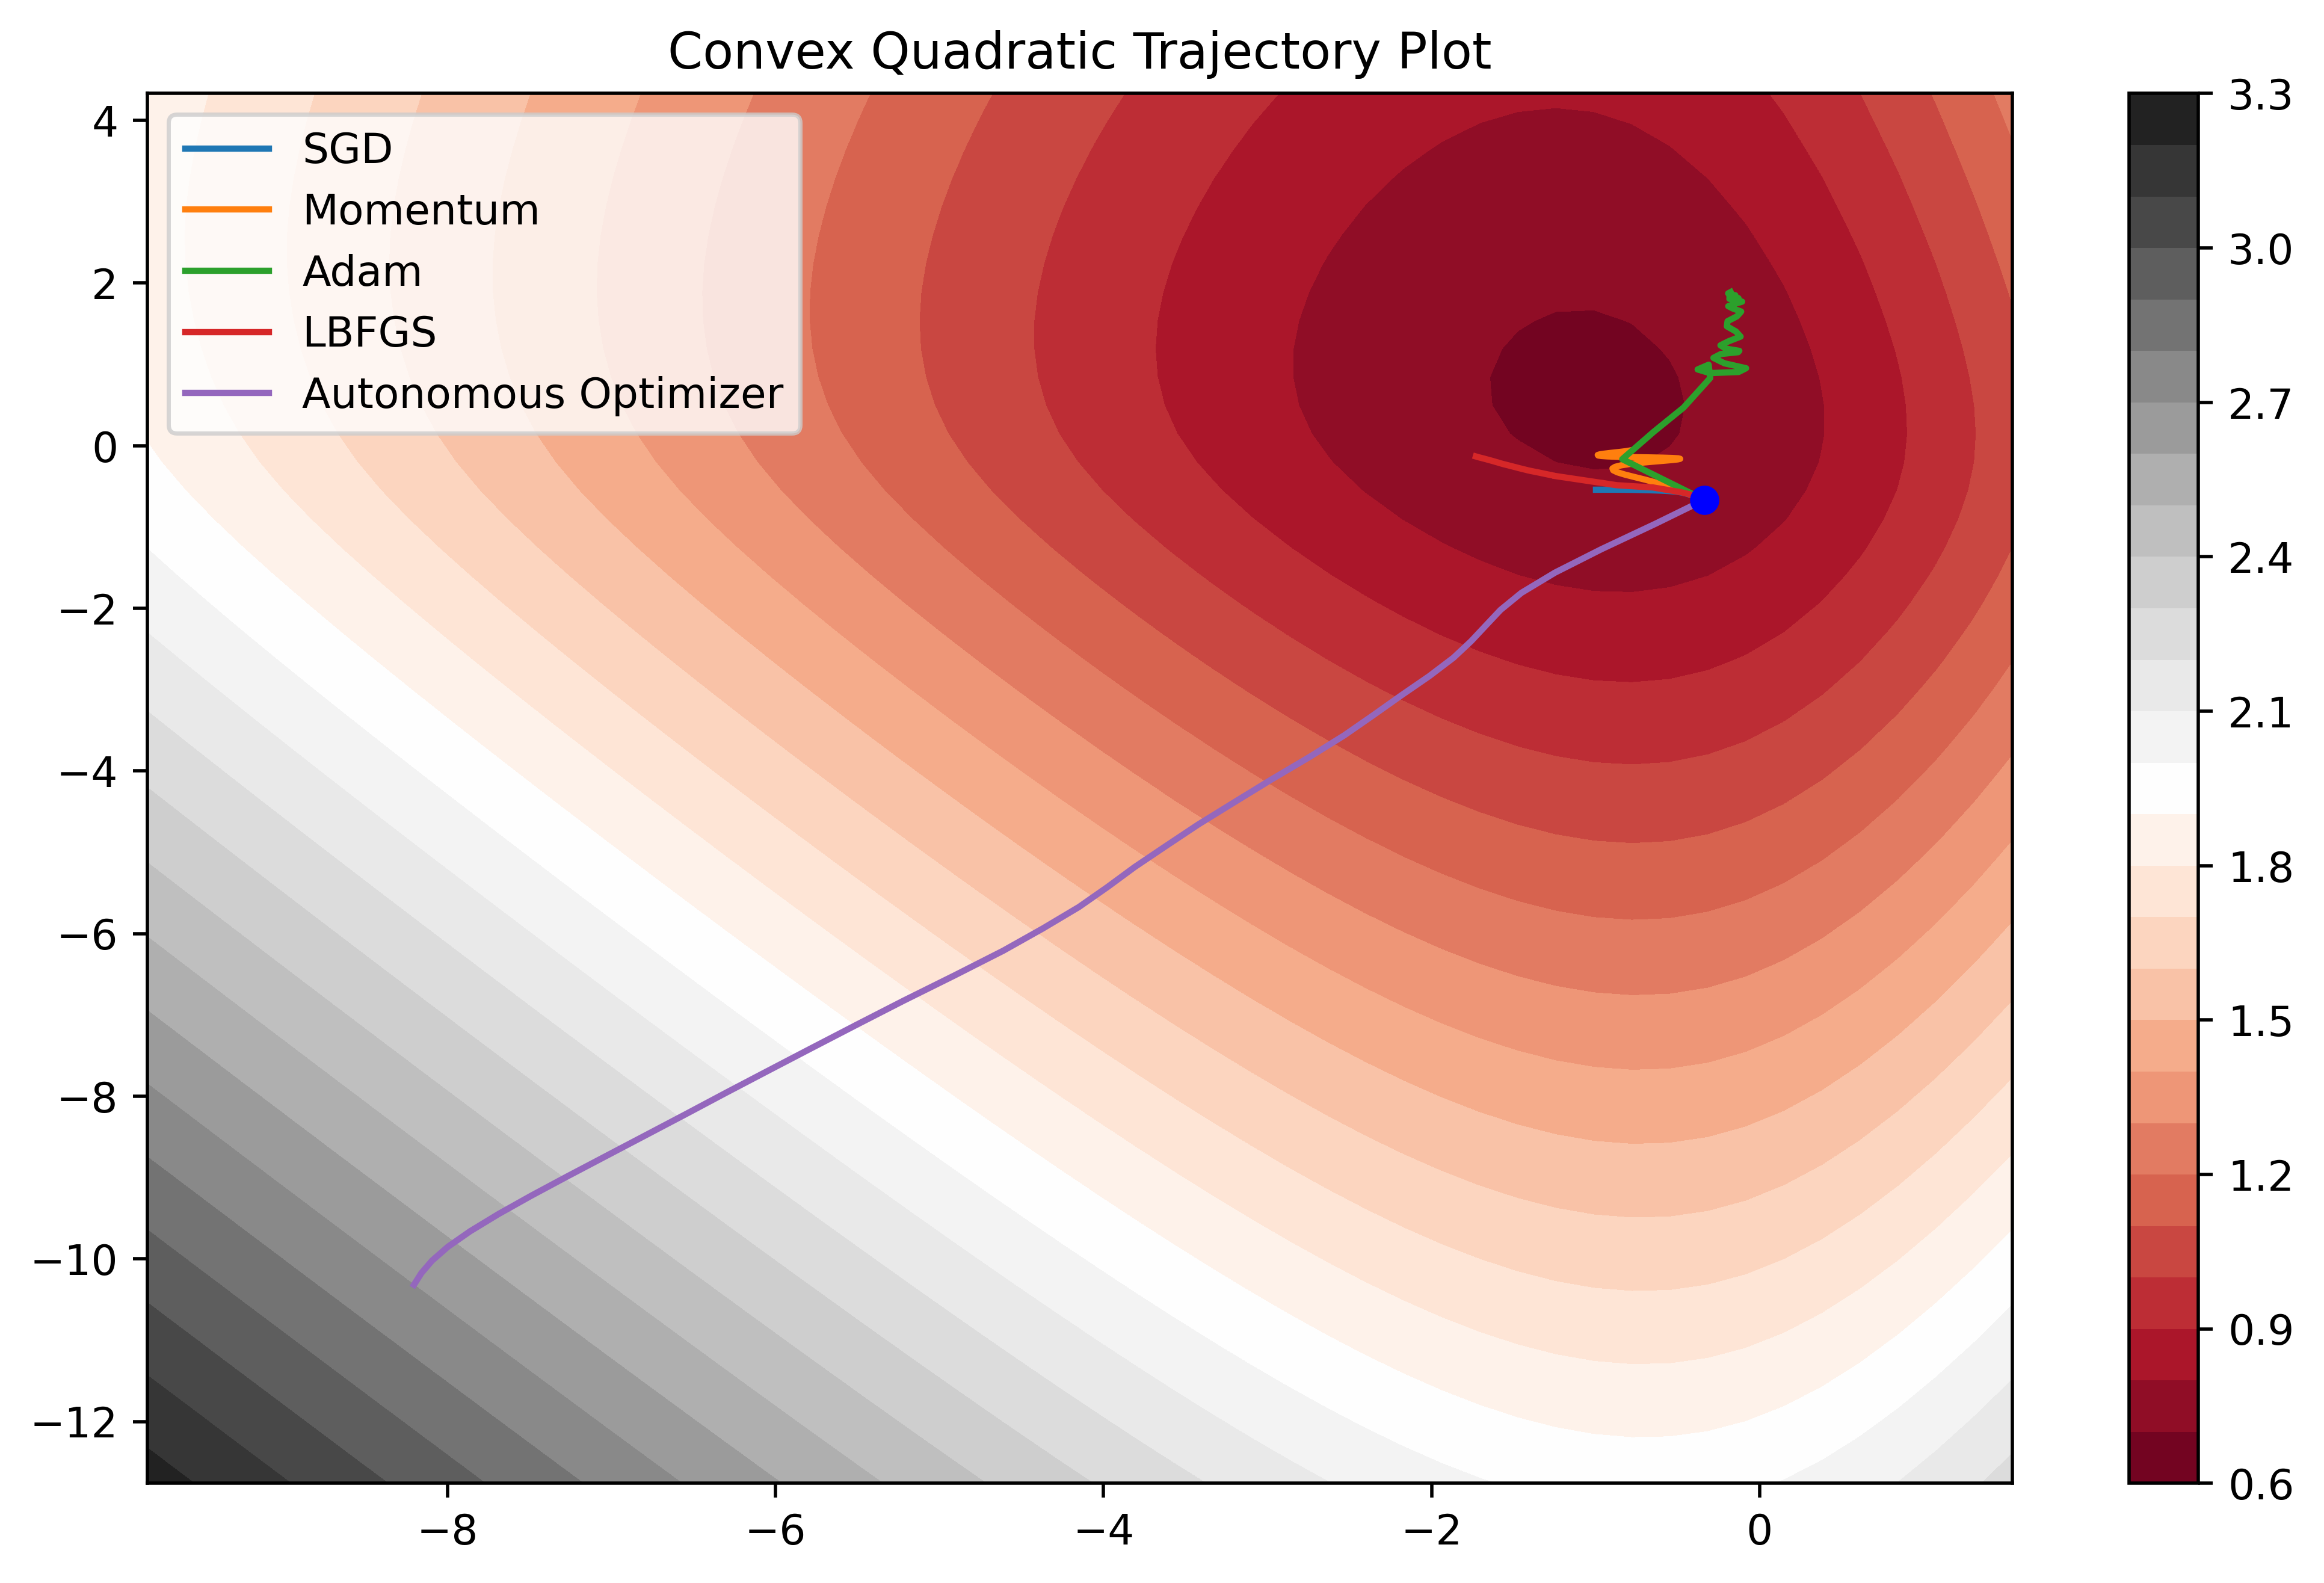

In [63]:
def get_weights(model):
    return model[2].weight[0, 0].item(), model[2].weight[0, 1].item()

def set_weights(model, w1, w2):
    with torch.no_grad():    
        model[2].weight[0, 0] = w1
        model[2].weight[0, 1] = w2

benchmark.plot_trajectories({
        'SGD': sgd_traj,
        'Momentum': momentum_traj,
        'Adam': adam_traj,
        'LBFGS': lbfgs_traj,
        'Autonomous Optimizer': ao_traj
    },
    problem, get_weights, set_weights)